# Bibliometric Analysis
## Based on Zotero CSV export

In [147]:
%pip install -q networkx

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime

Loading libraries

In [115]:
import pandas as pd

Loading data (exported from Zotero as CSV)

In [169]:
df = pd.read_csv('My Library.csv')

Renaming for easier plots/summaries

In [170]:
df = df.rename(columns={"Item Type": "Publication Type"})
df['Manual Tags'] = df['Manual Tags'].apply(lambda x: [tag.strip() for tag in x.split(';')] if isinstance(x, str) else [])
if 'Automatic Tags' not in df:
    df['Automatic Tags'] = ''  # in case the column is missing
df['Automatic Tags'] = df['Automatic Tags'].apply(lambda x: [tag.strip() for tag in x.split(';')] if isinstance(x, str) else [])

# Merge -> Tags (keep order, drop duplicates)
df['Tags'] = df['Manual Tags'] + df['Automatic Tags']
df['Publication Type'] = df['Publication Type'].replace('bookSection', 'Book Section').replace('conferencePaper', 'Conference Paper').replace('journalArticle', 'Journal Article')

Data preview

In [118]:
df[["Publication Type","Publication Year","Author","Title","Publication Title","Conference Name","Tags"]]

,Publication Type,Publication Year,Author,Title,Publication Title,Conference Name,Tags
0,Journal Article,2022,"Yang, Shiyu; Wan, Man Pun",Machine-learning-based model predictive control with instantaneous linearization–A case study on an air-conditioning and mechanical ventilation system,Applied Energy,NaN,"[case study, control strategy optimization, Machine learning, predictive control]"
1,Journal Article,2021,"Yang, Shiyu; Wan, Man Pun; Chen, Wanyu; Ng, Bing Feng; Dubey, Swapnil",Experiment study of machine-learning-based approximate model predictive control for energy-efficient building control,Applied Energy,NaN,"[adaptive control, Building energy modeling, experimental-study, hvac, machine learning, Model predictive control, real time control, reinforcment learning]"
2,Journal Article,2022,"Lee, Hyeongseok; Heo, Yeonsook",Simplified data-driven models for model predictive control of residential buildings,Energy and Buildings,NaN,"[arx, Building energy modeling, data-driven models, hvac, linear-model, Model predictive control, residential, simulation, thredhold model]"
3,Journal Article,2025,"Xie, Lingyun; Shan, Kui; Tang, Hong; Wang, Shengwei",AI-empowered online control optimization for enhanced efficiency and robustness of building central cooling systems,Advances in Applied Energy,NaN,"[ai-driven-control, deep-learning, hvac, hybrid models, Optimization, practical, real time control]"
4,Journal Article,2021,"Mariano-Hernández, Deyslen; Hernández-Callejo, Luis; Solís, Martín; Zorita-Lamadrid, Angel; Duque-Perez, Oscar; Gonzalez-Morales, Luis; Santos-García, Felix",A Data-Driven Forecasting Strategy to Predict Continuous Hourly Energy Demand in Smart Buildings,Applied Sciences,NaN,"[deep-learning, energy demand, Machine learning, multi-step forecasting, smart building, Time series forecasting, weather-data]"
5,Journal Article,2014,"Fan, Cheng; Xiao, Fu; Wang, Shengwei",Development of prediction models for next-day building energy consumption and peak power demand using data mining techniques,Applied Energy,NaN,"[arima, Building energy modeling, clustering, data mining, forecasting models, Machine learning, neural netwrok, outlier, random forest]"
6,Journal Article,2022,"Chen, Yongbao; Guo, Mingyue; Chen, Zhisen; Chen, Zhe; Ji, Ying",Physical energy and data-driven models in building energy prediction: A review,Energy Reports,NaN,"[Building energy modeling, calibration, energy forecasting, Machine learning, review, simulation, urban]"
7,Journal Article,2018,"Ahmad, Tanveer; Chen, Huanxin; Guo, Yabin; Wang, Jiangyu",A comprehensive overview on the data driven and large scale based approaches for forecasting of building energy demand: A review,Energy and Buildings,NaN,"[benchmarking, Building energy modeling, clustering, data-driven models, energy forecasting, hybrid models, Machine learning, model comparison, neural netwrok, regression, review, statistical models, support-vector-machine]"
8,Journal Article,2022,"Lin, Jing; Fernández, Julián A.; Rayhana, Rakiba; Zaji, Amirhossein; Zhang, Ran; Herrera, Omar E.; Liu, Zheng; Mérida, Walter",Predictive analytics for building power demand: Day-ahead forecasting and anomaly prediction,Energy and Buildings,NaN,"[anomaly detection, forecasting models, non-residential, pattern-mining, power-demand, predictive-analytics, smart building, Time series forecasting]"
9,Journal Article,2023,"Mascali, Lorenzo; Schiera, Daniele Salvatore; Eiraudo, Simone; Barbierato, Luca; Giannantonio, Roberta; Patti, Edoardo; Bottaccioli, Lorenzo; Lanzini, Andrea",A machine learning-based Anomaly Detection Framework for building electricity consumption data,"Sustainable Energy, Grids and Networks",NaN,"[anomaly detection, cart, contextual-anomalies, energy monitoring, mlp, semi-supervised learning, Telecommunications]"


In [123]:
%pip install -q plotly.express

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


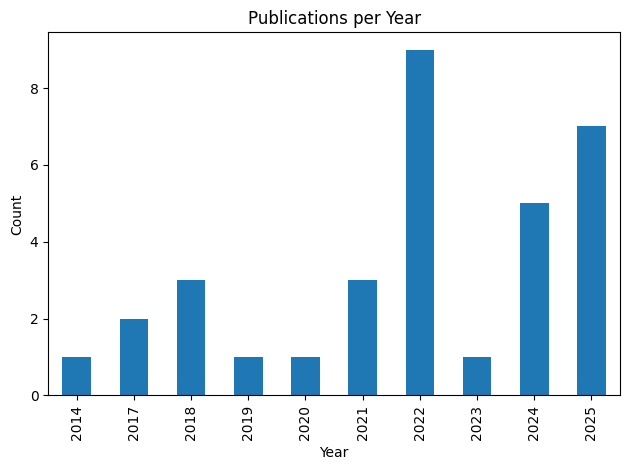

In [171]:
pubs_per_year = df['Publication Year'].dropna().astype(int).value_counts().sort_index()
pubs_per_year.plot(kind='bar')
plt.title("Publications per Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


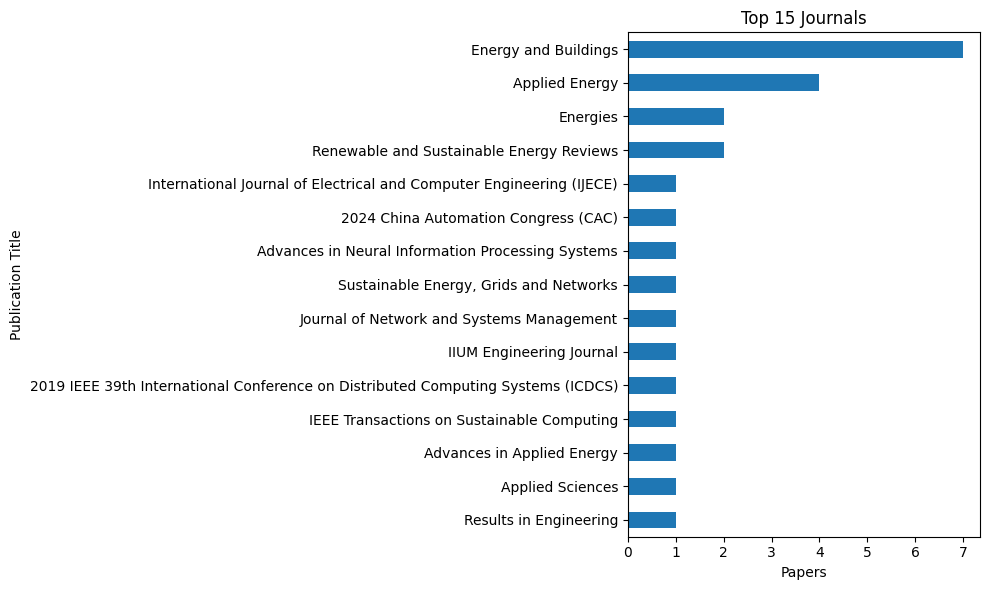

In [172]:
top_n = 15
ax = (df['Publication Title']
        .dropna()
        .value_counts()
        .head(top_n)
        .sort_values()
        .plot(kind='barh', figsize=(10, 6)))
plt.title(f"Top {top_n} Journals")
plt.xlabel("Papers")
plt.tight_layout(); plt.show()

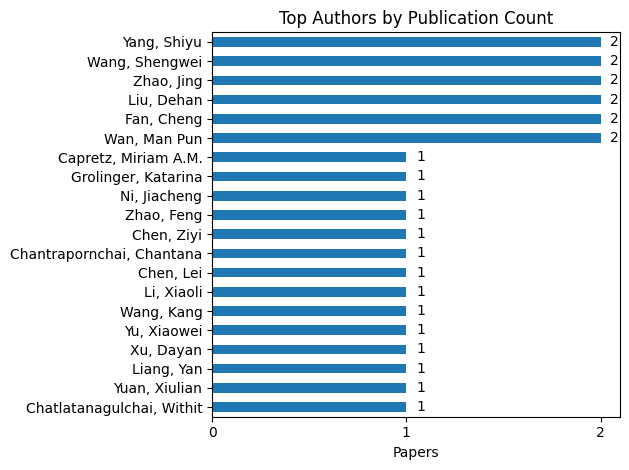

In [173]:
from matplotlib.ticker import MaxNLocator

# Build counts as integers
counts = (pd.Series(authors).value_counts()
          .head(20)
          .sort_values(ascending=True)
          .astype(int))

ax = counts.plot(kind='barh')
ax.set_title("Top Authors by Publication Count")
ax.set_xlabel("Papers")

# force integer ticks on the x-axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# annotate bars with integer values
for rect, val in zip(ax.patches, counts.values):
    ax.text(val + 0.05, rect.get_y() + rect.get_height()/2,
            f"{val}", va='center')

plt.tight_layout(); plt.show()


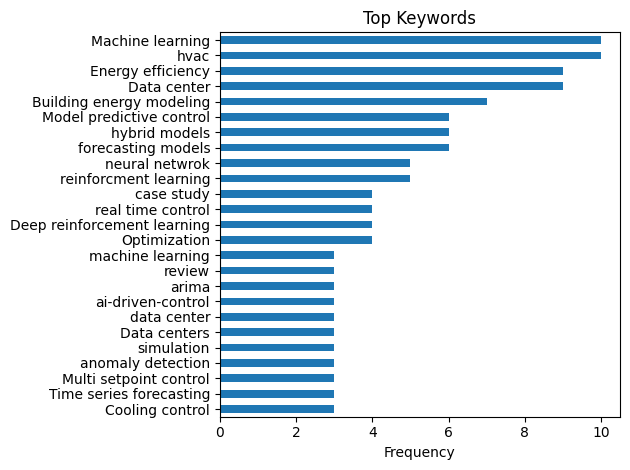

In [174]:
from collections import Counter
all_tags = [t for tags in df['Tags'] for t in tags]
cnt = pd.Series(Counter(all_tags)).sort_values(ascending=False).head(25).sort_values()
cnt.plot(kind='barh')
plt.title("Top Keywords")
plt.xlabel("Frequency")
plt.tight_layout(); plt.show()


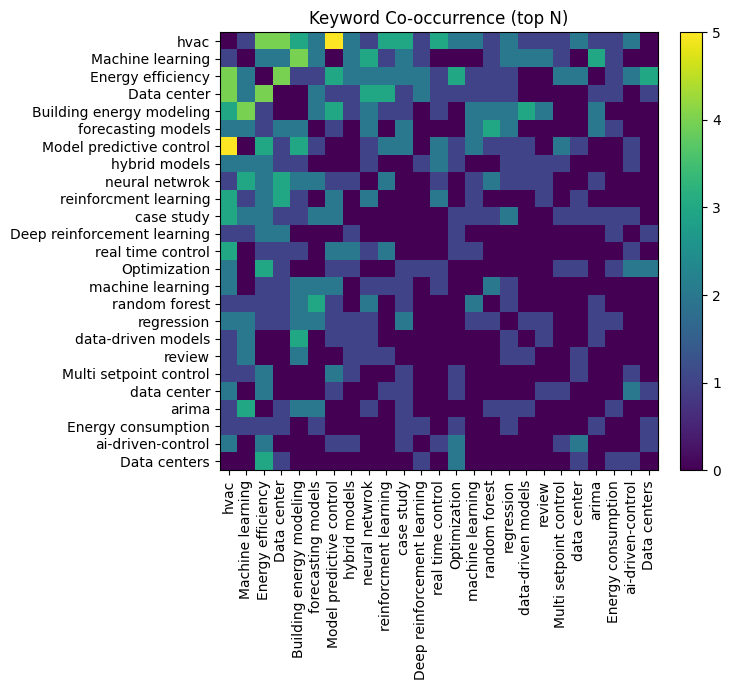

In [175]:
import numpy as np

topN = 25
top_tags = [t for t,_ in Counter(all_tags).most_common(topN)]
idx = {t:i for i,t in enumerate(top_tags)}
M = np.zeros((topN, topN), dtype=int)

for tags in df['Tags']:
    present = [t for t in tags if t in idx]
    for a in range(len(present)):
        for b in range(a+1, len(present)):
            i, j = idx[present[a]], idx[present[b]]
            M[i,j] += 1; M[j,i] += 1

fig, ax = plt.subplots(figsize=(8,7))
im = ax.imshow(M)
ax.set_xticks(range(topN)); ax.set_yticks(range(topN))
ax.set_xticklabels(top_tags, rotation=90); ax.set_yticklabels(top_tags)
plt.title("Keyword Co-occurrence (top N)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np

def rescale(arr, out_min, out_max):
    """Rescale a 1D list/array to [out_min, out_max]. Handles constant arrays."""
    x = np.asarray(arr, dtype=float)
    if x.size == 0:
        return x
    rng = np.ptp(x)  # <-- NumPy 2.0 safe
    if rng == 0:
        return np.full_like(x, (out_min + out_max) / 2.0)
    z = (x - x.min()) / rng
    return out_min + z * (out_max - out_min)

# --- replace your size/edge-width scaling with this: ---

# Node size by weighted degree
sizes = rescale([wdeg.get(n, 1) for n in H.nodes()], out_min=300, out_max=1800)

# Edge width by weight
ew = rescale([H[u][v]['weight'] for u, v in H.edges()], out_min=0.5, out_max=3.0)


AttributeError: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.

In [177]:
cit_col = None
for c in df.columns:
    if str(c).lower() in ["cited by", "times cited", "citations"]:
        cit_col = c; break

if cit_col:
    # Histogram (log x for skew)
    df[cit_col] = pd.to_numeric(df[cit_col], errors='coerce').fillna(0).astype(int)
    df[cit_col].clip(upper=df[cit_col].quantile(0.99)).plot(kind='hist', bins=30)
    plt.title("Citation Count Distribution")
    plt.xlabel("Citations")
    plt.tight_layout(); plt.show()

    # Top papers
    (df[['Title', 'Author', cit_col]]
        .sort_values(cit_col, ascending=False)
        .head(15)
        .set_index('Title')[cit_col]
        .sort_values()
        .plot(kind='barh'))
    plt.title("Top Cited Papers")
    plt.xlabel("Citations"); plt.tight_layout(); plt.show()
else:
    print("No citation-count column found (e.g., 'Cited by').")


No citation-count column found (e.g., 'Cited by').


## Publication Dynamics

Manual adjustment of the incomplete last year

In [178]:
year_item_counts = df.groupby(['Publication Year', 'Publication Type']).size().unstack(fill_value=0)
year_item_counts_adjusted = year_item_counts.copy()
if 2024 in year_item_counts_adjusted.index:
    year_item_counts_adjusted.loc[2024] = np.round(year_item_counts_adjusted.loc[2024] * 365/294) #21-Oct

Plotting the dynamics

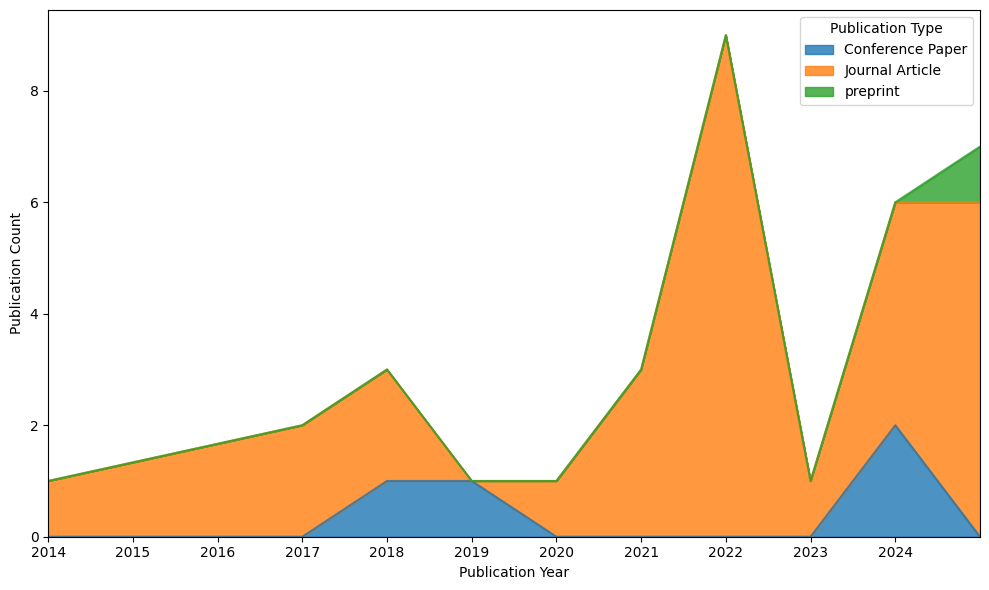

In [179]:
year_item_counts_adjusted.plot(kind='area', stacked=True, alpha=0.8, figsize=(10, 6))
plt.xlabel('Publication Year')
plt.ylabel('Publication Count')
plt.xlim(2014, 2025)
plt.xticks(range(2014, 2025))
plt.legend(title='Publication Type')
plt.tight_layout()
plt.show();

## Most cited papers

Collecting citations using Open REST API for COCI, the OpenCitations Index of Crossref

In [180]:
def get_citation_count(doi):
    base_url = "https://opencitations.net/index/coci/api/v1/citations/"
    url = f"{base_url}{doi}"
    if (pd.isna(doi)):
        return np.nan
    try:
        response = requests.get(url)
        response.raise_for_status()
        citations = response.json()
        citation_count = len(citations)
        print(".", end="")
        return citation_count
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return np.nan
df['CitationCount'] = df['DOI'].apply(get_citation_count)

.....................An error occurred: 404 Client Error: Not Found for url: https://api.opencitations.net/index/v1/citations/10.31436/iiumej.v26i3.3629
.........

Plotting citation counts

/var/folders/0v/5q7y7jh96kvgp0h0vjs0r3qw0000gn/T/ipykernel_86186/309523660.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


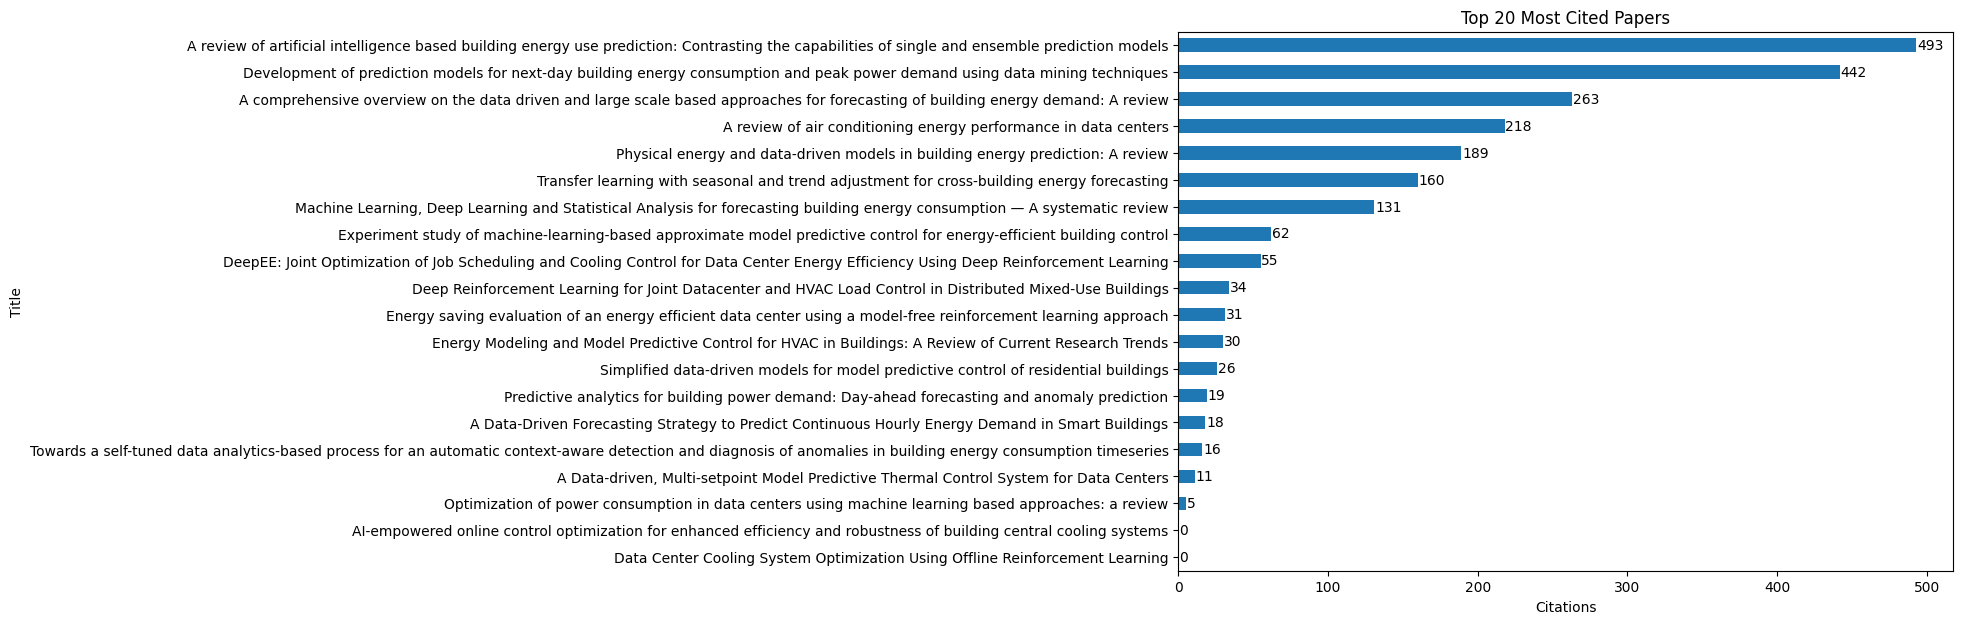

In [181]:
import matplotlib.pyplot as plt
import numpy as np

top = (df[['Title','Author','CitationCount']]
       .dropna(subset=['CitationCount'])
       .assign(CitationCount=lambda d: d['CitationCount'].astype(int))
       .sort_values('CitationCount', ascending=False)
       .head(20))

ax = top.sort_values('CitationCount').plot(
    kind='barh', x='Title', y='CitationCount', legend=False, figsize=(10,7))
ax.set_title("Top 20 Most Cited Papers")
ax.set_xlabel("Citations")
for r, v in zip(ax.patches, top.sort_values('CitationCount')['CitationCount']):
    ax.text(v + 0.5, r.get_y()+r.get_height()/2, str(int(v)), va='center')
plt.tight_layout(); plt.show()


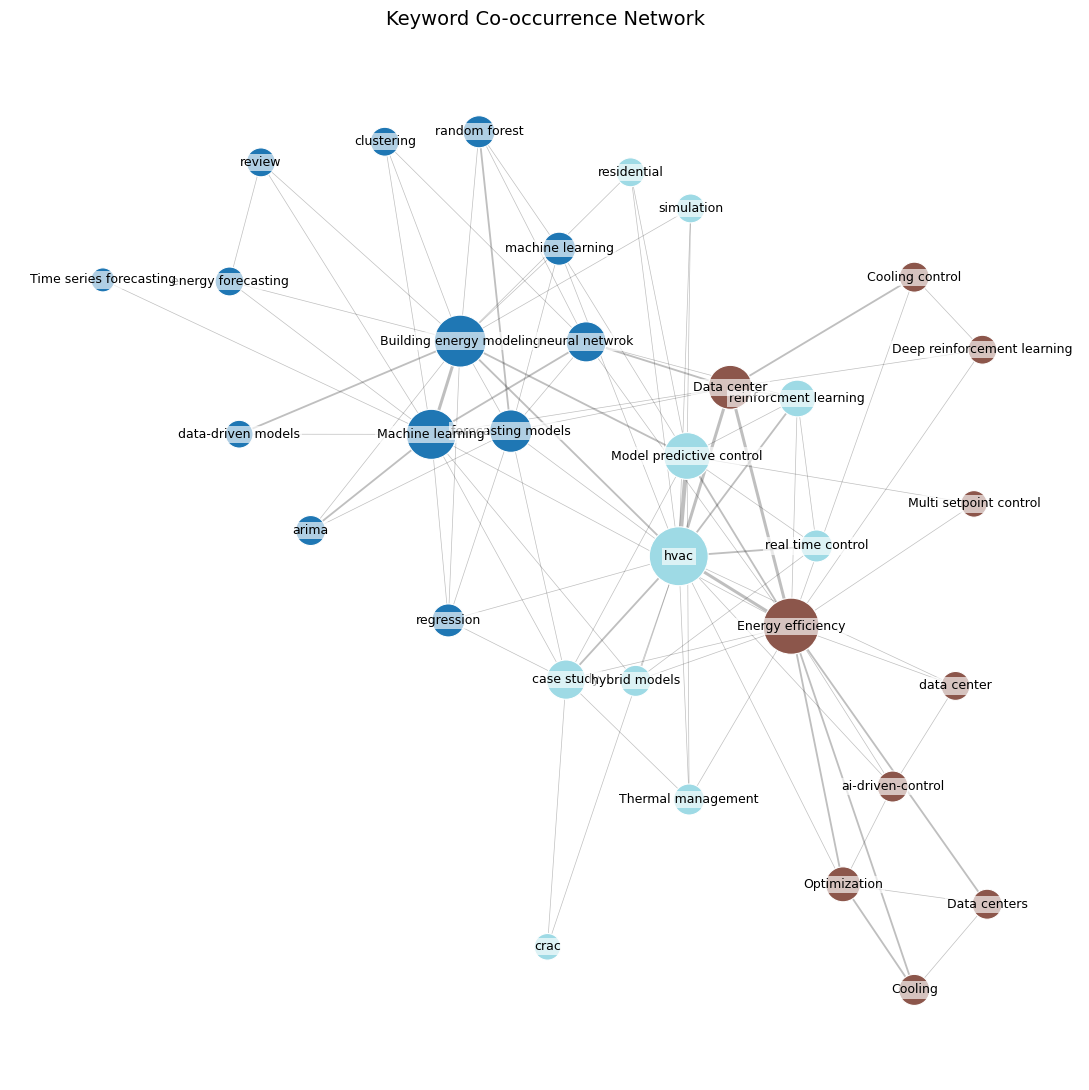

In [192]:
# ========================= Keyword Co-occurrence Network =========================
# Tunables
TOP_N_TAGS       = 40     # use the top-N most frequent tags
MIN_EDGE_WEIGHT  = 2      # drop co-occurrences below this
MIN_DEGREE       = 2      # drop low-degree nodes to reduce clutter
MAX_LABELS       = 60     # label only the most important nodes
SEED             = 42

from collections import Counter
from itertools import combinations
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# ---------- helper: robust rescale (NumPy 2.0 safe) ----------
def rescale(arr, out_min, out_max):
    """Rescale a 1D list/array to [out_min, out_max]. Handles empty/constant arrays."""
    x = np.asarray(arr, dtype=float)
    if x.size == 0:
        return x
    rng = np.ptp(x)  # NumPy 2.0 safe (instead of x.ptp())
    if rng == 0:
        return np.full_like(x, (out_min + out_max) / 2.0)
    z = (x - x.min()) / rng
    return out_min + z * (out_max - out_min)

# ---------- 1) Build graph ----------
all_tags = [t for tags in df['Tags'] for t in tags]
top_tags = set([t for t, _ in Counter(all_tags).most_common(TOP_N_TAGS)])

edge_w = Counter()
for tags in df['Tags']:
    tags_f = sorted(set(t for t in tags if t in top_tags))
    for a, b in combinations(tags_f, 2):
        edge_w[(a, b)] += 1

G = nx.Graph()
for (a, b), w in edge_w.items():
    if w >= MIN_EDGE_WEIGHT:
        G.add_edge(a, b, weight=w)

# ---------- 2) Prune low-degree nodes ----------
to_keep = [n for n, d in G.degree() if d >= MIN_DEGREE]
H = G.subgraph(to_keep).copy()
if H.number_of_nodes() == 0:  # fallback if too strict
    H = G.copy()

# ---------- 3) Importance & communities ----------
deg  = dict(H.degree())
wdeg = dict(H.degree(weight='weight'))
betw = nx.betweenness_centrality(H, weight='weight', seed=SEED)

try:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = list(greedy_modularity_communities(H, weight='weight'))
    comm_id = {}
    for i, c in enumerate(comms):
        for n in c:
            comm_id[n] = i
except Exception:
    comm_id = {n: 0 for n in H.nodes()}

# ---------- 4) Visual encodings (sizes, colors, widths) ----------
sizes = rescale([wdeg.get(n, 1) for n in H.nodes()], out_min=300, out_max=1800)   # node size by weighted degree
ew    = rescale([H[u][v]['weight'] for u, v in H.edges()], out_min=0.5, out_max=3.0)  # edge width by weight

num_comms = max(comm_id.values()) + 1 if H.nodes() else 1
cmap_nodes = plt.cm.tab20 if num_comms <= 20 else plt.cm.nipy_spectral
node_colors = [cmap_nodes(comm_id[n] / max(num_comms - 1, 1)) for n in H.nodes()]

# ---------- 5) Layout ----------
k = 0.6 / np.sqrt(max(len(H), 1))  # auto spacing by graph size
pos = nx.spring_layout(H, k=k, iterations=200, weight='weight', seed=SEED)

# ---------- 6) Draw ----------
plt.figure(figsize=(11, 11))
nx.draw_networkx_edges(H, pos, width=ew, edge_color=(0, 0, 0, 0.25))
nx.draw_networkx_nodes(
    H, pos,
    node_size=sizes,
    node_color=node_colors,
    linewidths=0.8,
    edgecolors='white'   # white halo for readability
)

# label only most important nodes (blend weighted degree + betweenness)
importance = {n: 0.8*wdeg.get(n, 0) + 0.2*betw.get(n, 0) for n in H.nodes()}
keep_labels = set(sorted(importance, key=importance.get, reverse=True)[:MAX_LABELS])
labels = {n: n for n in H.nodes() if n in keep_labels}
nx.draw_networkx_labels(
    H, pos, labels=labels,
    font_size=9, font_weight='regular',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, pad=1.5)
)

plt.title("Keyword Co-occurrence Network", fontsize=14, pad=12)
plt.axis('off')
plt.tight_layout()
plt.show()
# ================================================================================

/var/folders/0v/5q7y7jh96kvgp0h0vjs0r3qw0000gn/T/ipykernel_86186/618547378.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


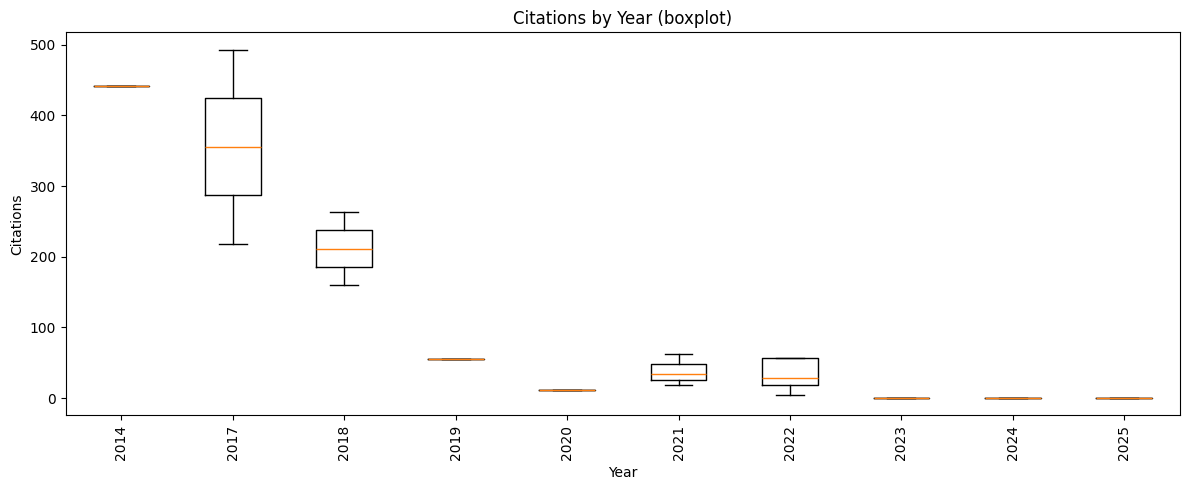

In [187]:
d = df.dropna(subset=['Publication Year','CitationCount']).copy()
d['Publication Year'] = d['Publication Year'].astype(int)
d['CitationCount'] = pd.to_numeric(d['CitationCount'], errors='coerce').fillna(0).astype(int)

years = sorted(d['Publication Year'].unique())
data = [d.loc[d['Publication Year']==y, 'CitationCount'] for y in years]

plt.figure(figsize=(12,5))
plt.boxplot(data, labels=years, showfliers=False)
plt.title("Citations by Year (boxplot)")
plt.xlabel("Year"); plt.ylabel("Citations")
plt.xticks(rotation=90)
plt.tight_layout(); plt.show()


Citation summary: {'n': 30, 'mean': 73.43333333333334, 'median': 17.0, 'min': 0.0, 'p90': 222.50000000000006, 'p95': 361.4499999999995, 'p99': 478.21000000000004, 'max': 493.0}


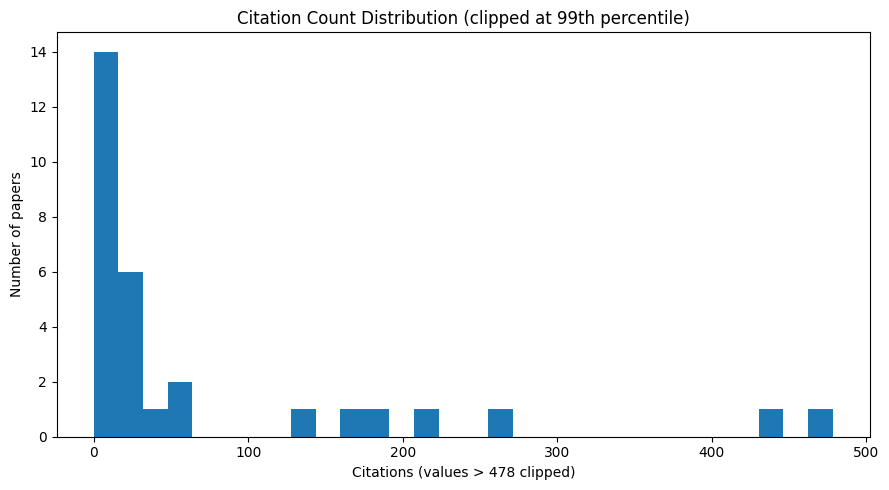

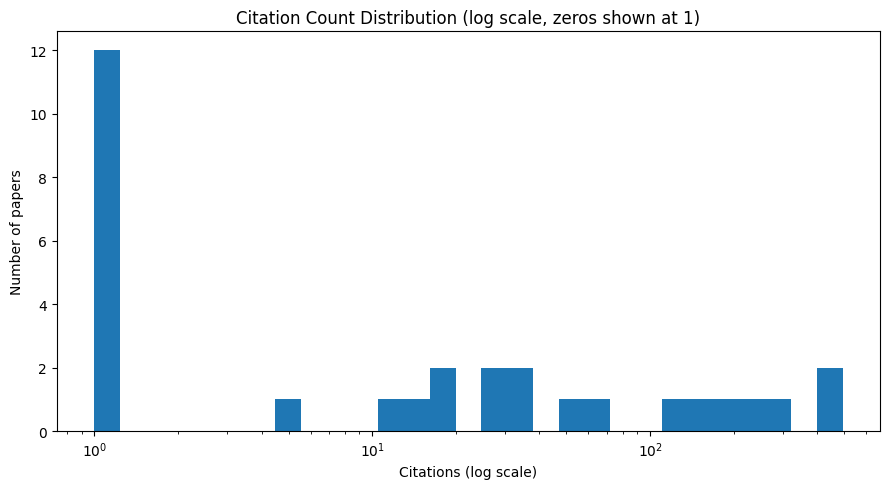

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- pick the citation column (robust to different names) ---
candidates = [c for c in df.columns if str(c).lower() in ("citationcount","citations","cited by","times cited")]
if not candidates:
    raise ValueError("No citation column found (expected 'CitationCount' / 'Cited by' / 'Times Cited').")
CIT_COL = candidates[0]

# numeric, nonnegative
cit = pd.to_numeric(df[CIT_COL], errors="coerce").dropna()
cit = cit[cit >= 0]

# ---- summary stats ----
summary = {
    "n": int(cit.size),
    "mean": float(cit.mean()),
    "median": float(cit.median()),
    "min": float(cit.min()),
    "p90": float(cit.quantile(0.90)),
    "p95": float(cit.quantile(0.95)),
    "p99": float(cit.quantile(0.99)),
    "max": float(cit.max()),
}
print("Citation summary:", summary)

# =========== (A) Histogram with 99th percentile clipping ===========
q99 = cit.quantile(0.99)
plt.figure(figsize=(9,5))
plt.hist(cit.clip(upper=q99), bins=30)
plt.title("Citation Count Distribution (clipped at 99th percentile)")
plt.xlabel(f"Citations (values > {int(q99)} clipped)"); plt.ylabel("Number of papers")
plt.tight_layout(); plt.show()

# =========== (B) Histogram on log x-axis (keeps outliers) ===========
# use log-spaced bins; shift zeros to 1 for log display
cit_pos = cit.replace(0, 1)
bins = np.logspace(np.log10(cit_pos.min()), np.log10(max(cit_pos.max(), 1)), 30)
plt.figure(figsize=(9,5))
plt.hist(cit_pos, bins=bins)
plt.xscale('log')
plt.title("Citation Count Distribution (log scale, zeros shown at 1)")
plt.xlabel("Citations (log scale)"); plt.ylabel("Number of papers")
plt.tight_layout(); plt.show()


Top 10 most cited papers

In [188]:
pd.set_option('display.max_colwidth', None)
df[["Author","Title","Publication Year","Publication Title","CitationCount"]].head(10)

,Author,Title,Publication Year,Publication Title,CitationCount
0,"Abdul-Zahra, Amar S.; Al-Haddad, Luttfi A.; Abdulsahib, I.A.; Kraiem, Habib; Flah, Aymen",Sustainable thermal load prediction in residential buildings using machine learning: A case study analysis,2025,Results in Engineering,0.0
1,"Ahmad, Tanveer; Chen, Huanxin; Guo, Yabin; Wang, Jiangyu",A comprehensive overview on the data driven and large scale based approaches for forecasting of building energy demand: A review,2018,Energy and Buildings,263.0
2,"Bozorgi, Mehran; Tasnim, Syeda Humaira; Mahmud, Shohel",Machine learning-driven hybrid cooling system for enhanced energy efficiency in multi-unit residential buildings,2025,Energy and Buildings,0.0
3,"Chang, Qiankun; Huang, Yuanfeng; Liu, Kaiyan; Xu, Xin; Zhao, Yaohua; Pan, Song",Optimization Control Strategies and Evaluation Metrics of Cooling Systems in Data Centers: A Review,2024,Sustainability,0.0
4,"Chatlatanagulchai, Withit; Chantrapornchai, Chantana",Energy consumption data collection: case study on data center in a Thai University,2024,Energy Informatics,0.0
5,"Chen, Lei; Li, Xiaoli; Wang, Kang; Yu, Xiaowei",Optimization of Energy Efficiency of Data Center Cooling Systems,2024,2024 36th Chinese Control and Decision Conference (CCDC),0.0
6,"Chen, Yongbao; Guo, Mingyue; Chen, Zhisen; Chen, Zhe; Ji, Ying",Physical energy and data-driven models in building energy prediction: A review,2022,Energy Reports,189.0
7,"Chiosa, Roberto; Piscitelli, Marco Savino; Fan, Cheng; Capozzoli, Alfonso",Towards a self-tuned data analytics-based process for an automatic context-aware detection and diagnosis of anomalies in building energy consumption timeseries,2022,Energy and Buildings,16.0
8,"Fan, Cheng; Xiao, Fu; Wang, Shengwei",Development of prediction models for next-day building energy consumption and peak power demand using data mining techniques,2014,Applied Energy,442.0
9,"Khalil, Mohamad; McGough, A. Stephen; Pourmirza, Zoya; Pazhoohesh, Mehdi; Walker, Sara","Machine Learning, Deep Learning and Statistical Analysis for forecasting building energy consumption — A systematic review",2022,Engineering Applications of Artificial Intelligence,131.0


## Most popular journals and conferences

Most popular journals - overall and last 5 years

In [189]:
top = 20
title = "Publication Title"
pd.merge(df[title].value_counts().reset_index(), 
         df.loc[df["Publication Year"] >= datetime.datetime.now().year-5,title].value_counts().reset_index(),
         on=title, how='outer').head(top)

,Publication Title,count_x,count_y
0,2019 IEEE 39th International Conference on Distributed Computing Systems (ICDCS),1,NaN
1,2024 36th Chinese Control and Decision Conference (CCDC),1,1.0
2,2024 China Automation Congress (CAC),1,1.0
3,Advances in Applied Energy,1,1.0
4,Advances in Neural Information Processing Systems,1,NaN
5,Applied Energy,4,3.0
6,Applied Sciences,1,1.0
7,Applied Thermal Engineering,1,1.0
8,Energies,2,2.0
9,Energy Informatics,1,1.0


Making conference titles consistent

In [99]:
title = "Conference Name"
df[title] = df[title].where(~df[title].str.contains('IWSHM', case=False, na=False), 'IWSHM')
df[title] = df[title].where(~df[title].str.contains('AIAA SciTech Forum', case=False, na=False), 'AIAA SciTech Forum')
df[title] = df[title].str.replace('Proceedings - ', '').str.replace('(Proceedings)', '').str.replace('Proceedings of ', '').\
    str.replace('Proceedings', '').str.replace(r'\b\d{4}\b', '', regex=True).str.replace(r'\b\d{1,2}(st|nd|rd|th)\b', '', regex=True).\
    str.replace('the ', '').str.strip()

Most popular conferences - overall and last 5 years

In [100]:
pd.merge(df[title].value_counts().reset_index(), 
         df.loc[df["Publication Year"] >= datetime.datetime.now().year-5,title].value_counts().reset_index(),
         on=title, how='outer').head(top)

,Conference Name,count_x,count_y
0,China Automation Congress (CAC),1,1.0
1,Chinese Control and Decision Conference (CCDC),1,1.0
2,IEEE International Conference on Distributed Computing Systems (ICDCS),1,NaN


# Manual Tag Analysis

Counting manual tags by years

In [190]:
exploded_df = df.explode('Manual Tags')
tag_counts_by_year = exploded_df.groupby(['Publication Year', 'Manual Tags']).size().unstack(fill_value=0)
tag_counts_by_year_adjusted = tag_counts_by_year.copy()


Adjusting the incomplete year

In [191]:
if 2024 in tag_counts_by_year_adjusted.index:
    tag_counts_by_year_adjusted.loc[2024] = np.round(tag_counts_by_year_adjusted.loc[2024] * 365/294)
all_years = pd.DataFrame(index=range(1984, 2024))
tag_counts_by_year_adjusted = all_years.join(tag_counts_by_year_adjusted, how='outer').fillna(0)

### AI-related tag group

Plotting the dynamics

In [20]:
AI_areas = ['1.1. Knowledge-based', '1.2. Reasoning','2.1. Conventional ML','2.2. Deep Learning', '3. Digital Representation Technologies']
filtered_tag_counts_by_year = tag_counts_by_year_adjusted[AI_areas]
colors = ['#1386CC', '#00BFFF', '#FFA500', '#FF4500', '#800080'] 
plt.figure(figsize=(12, 6))

filtered_tag_counts_by_year.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6), alpha=0.7)

plt.title('Changes in Tag Counts by Year')
plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.legend(title='Manual Tags', loc='upper left') 
plt.grid()
plt.xticks(ticks=range(len(filtered_tag_counts_by_year.index)), 
           labels=filtered_tag_counts_by_year.index)
plt.gca().set_xticks(plt.gca().get_xticks()[::4])
plt.grid(False)
plt.tight_layout()
plt.show()

KeyError: "None of [Index(['1.1. Knowledge-based', '1.2. Reasoning', '2.1. Conventional ML',\n       '2.2. Deep Learning', '3. Digital Representation Technologies'],\n      dtype='object')] are in the [columns]"

AI Tag Hierarchy

In [21]:
tag_counts_by_year_adjustedAI = tag_counts_by_year_adjusted.loc[:, tag_counts_by_year_adjusted.columns.str.startswith(('1', '2', '3'))]
tag_sums = tag_counts_by_year_adjustedAI.sum()
tag_sums = pd.concat([pd.Series([len(df)], index=["AI in Aviation Maintenance"]), tag_sums])
tag_sums

/var/folders/0v/5q7y7jh96kvgp0h0vjs0r3qw0000gn/T/ipykernel_86186/1071535430.py:3: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  tag_sums = pd.concat([pd.Series([len(df)], index=["AI in Aviation Maintenance"]), tag_sums])


AI in Aviation Maintenance    34
dtype: int64

In [17]:
from plotly.colors import qualitative
import plotly.graph_objects as go
import plotly.colors as colors
import re

hierarchy = {
    'AI in Aviation Maintenance': {
        '1. Logic/Knowledge': {
            '1.1. Knowledge-based': [
                '1.1.1. Expert systems'
            ],
            '1.2. Reasoning': {
                '1.2.1. Case-based Reasoning': [],
                '1.2.2. Bayesian Reasoning': [],
                '1.2.3. Fuzzy Logic': [],
                '1.2.4. Markov Models': []
            }
        },
        '2. ML': {
            '2.1. Conventional ML': [
                '2.1.1. FFNN',
                '2.1.2. SVM',
                '2.1.3. Random Forest',
                '2.1.4. Decision Tree',
                '2.1.5. SOM'
            ],
            '2.2. Deep Learning': {
                '2.2.1. CNN': [
                    '2.2.1.1. YOLO'
                ],
                '2.2.2. GAN': [],
                '2.2.3. RNN': [
                    '2.2.3.1. LSTM',
                    '2.2.3.2. GRU'
                ],
                '2.2.4. DBN': [],
                '2.2.5. Autoencoder': [],
                '2.2.6. Transformer': [],
                '2.2.7. Transfer Learning': [],
                '2.2.8. Ensemble': [
                    '2.2.8.1. Boosting'
                ]
    },
            '2.3. Reinforcement': []
        },
        '3. Digital Representation Technologies': {
            '3.1. Augmented Reality': [],
            '3.2. Digital Twin': []
        }
    }
}

sources = []
targets = []
values = []

def format_node(s,tag_sums):
    return re.sub(r'^\d+(\.\d+)*\.?\s*', '', s)+" ("+str(int(tag_sums[s]))+")"
def generate_pairs(source, sublevels):
    for sublevel, items in sublevels.items():
        sources.append(format_node(source, tag_sums))
        targets.append(format_node(sublevel, tag_sums))
        values.append(tag_sums[sublevel])
        if isinstance(items, list):
            for item in items:
                sources.append(format_node(sublevel, tag_sums))
                targets.append(format_node(item, tag_sums))
                values.append(tag_sums[item])
        elif isinstance(items, dict):
            generate_pairs(sublevel, items)

for main_level, subcategories in hierarchy.items():
    generate_pairs(main_level, subcategories)

sankey_df = pd.DataFrame({
    'Source': sources,
    'Target': targets,
    'Value': values
})

unique_labels = [format_node(s,tag_sums) for s in tag_sums.index.tolist()]
label_to_index = {label: index for index, label in enumerate(unique_labels)}

sankey_source_indices = [label_to_index[src] for src in sources]
sankey_target_indices = [label_to_index[tgt] for tgt in targets]
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=unique_labels,
    x=[0,#'AI-related papers in Aviation Maintenance',
        1/4,#'1. Logic/Knowledge',
        2/4,#'1.1. Knowledge-based',
        3/4,#'1.1.1. Expert systems',
         2/4,#'1.2. Reasoning',
         3/4,#'1.2.1. Case-based Reasoning',
         3/4,#'1.2.2. Bayesian Reasoning',
         3/4,#'1.2.3. Fuzzy Logic',
         3/4,#'1.2.4. Markov Models',
              1/4,#'2. ML',
             2/4,#'2.1. Conventional Machine Learning',
             3/4,#'2.1.1. FFNN',
             3/4,#'2.1.2. SVM',
             3/4,#'2.1.3. Random Forest',
             3/4,#'2.1.4. Decision Tree',
             3/4,#'2.1.5. SOM',
             2/4,#'2.2. Deep Learning',
             3/4,#'2.2.1. CNN',
              4/4,#'2.2.1.1. YOLO',
             3/4,#'2.2.2. GAN',
             3/4,#'2.2.3. RNN',
                        4/4,#'2.2.3.1. LSTM',
              4/4,#'2.2.3.2. GRU',
             3/4,#'2.2.4. DBN',
             3/4,#'2.2.5. Autoencoder',
             3/4,#'2.2.6. Transformer',
             3/4,#'2.2.7. Transfer Learning',
             3/4,#'2.2.8. Ensemble',
              4/4,#'2.2.8.1. Boosting',
             2/4,#'2.3. Reinforcement',
             1/4,#'3. Digital Representation Technologies',
             2/4,#'3.1. Augmented Reality',
             2/4,#'3.2. Digital Twin'
           ],
        y=[x/len(unique_labels) for x in range(0, len(unique_labels))],
        color= colors.sample_colorscale('Plasma', [i/(len(unique_labels) - 1) for i in range(len(unique_labels))])
    ),
    link=dict(
        source=sankey_source_indices,  # Indices correspond to labels
        target=sankey_target_indices,
        color="#DEDEDE",
        value=values
    ),
    arrangement = "snap"
))

# Customize the layout
fig.update_layout(font=dict(size=24, color='black'), 
                   width=2000, height=1200)
fig.show(renderer='browser')

### AM-related tag group

Plotting the dynamics

<Figure size 1200x600 with 0 Axes>

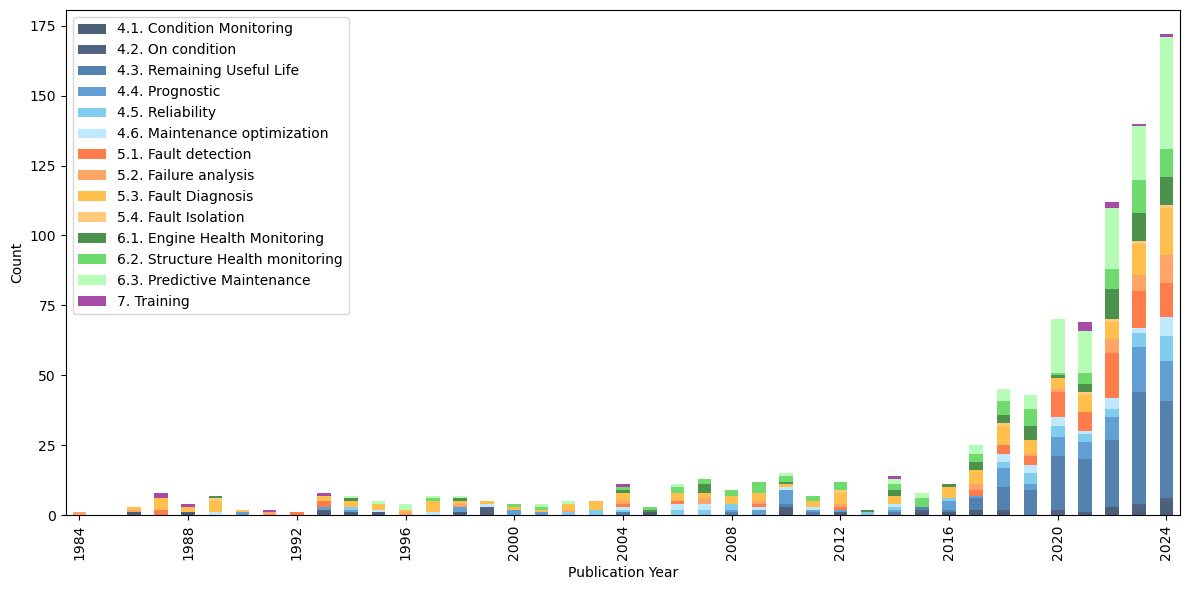

In [18]:
AM_areas = ['4.1. Condition Monitoring','4.2. On condition',
                                                           '4.3. Remaining Useful Life',
                                                           '4.4. Prognostic',
                                                           '4.5. Reliability',
                                                           '4.6. Maintenance optimization',
                                                           '5.1. Fault detection', 
                                                           '5.2. Failure analysis', 
                                                           '5.3. Fault Diagnosis', 
                                                           '5.4. Fault Isolation', 
                                                           '6.1. Engine Health Monitoring',
                                                           '6.2. Structure Health monitoring',
                                                           '6.3. Predictive Maintenance',
                                                           '7. Training']
filtered_tag_counts_by_year = tag_counts_by_year_adjusted[AM_areas]
cls = [
    '#001D3D',  # Almost black navy blue
    '#0A1E4E',  # Very deep blue
    '#0A4D8C',  # Deep blue
    '#1F76C2',  # Bright, vibrant blue
    '#4CB8E6',  # Light azure blue
    '#A6E1FF',  # Very pale blue
    
    '#FF4500',
    '#FF7F24',
    '#FFA500',
    '#FFB347',
    
    '#006400',  # Dark Green
    '#32CD32',  # Lime Green
    '#98FB98',
    
    '#800080'
]
plt.figure(figsize=(12, 6))

filtered_tag_counts_by_year.plot(kind='bar', stacked=True, color=cls, figsize=(12, 6), alpha=0.7)

# Customize the plot
plt.xlabel('Publication Year')
plt.ylabel('Count')
plt.legend(loc='upper left')  # Adjust legend position
plt.grid()
plt.xticks(ticks=range(len(filtered_tag_counts_by_year.index)), 
           labels=filtered_tag_counts_by_year.index)
plt.gca().set_xticks(plt.gca().get_xticks()[::4])
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
tag_counts_by_year_adjustedAM = tag_counts_by_year_adjusted.loc[:, tag_counts_by_year_adjusted.columns.str.startswith(('4', '5', '6', '7'))]
tag_sums = tag_counts_by_year_adjustedAM.sum()
tag_sums = pd.concat([pd.Series([len(df)], index=["AI in Aviation Maintenance"]), tag_sums])
tag_sums

AI in Aviation Maintenance                   657.0
4. CAWM                                      312.0
4.1. Condition Monitoring                     28.0
4.2. On condition                             10.0
4.3. Remaining Useful Life                   165.0
4.4. Prognostic                               83.0
4.4.1. Prognostic: Engine                     47.0
4.4.2. Prognostic: Airframe                   17.0
4.4.3. Prognostic: Aircraft system            15.0
4.5. Reliability                              44.0
4.6. Maintenance optimization                 36.0
5. MRO                                       216.0
5.1. Fault detection                          74.0
5.2. Failure analysis                         36.0
5.2.1. Failure Analysis: Engine               10.0
5.2.2. Failure Analysis: Airframe              3.0
5.2.3. Failure Analysis: Aircraft systems      8.0
5.3. Fault Diagnosis                         121.0
5.3.1. Fault Diagnosis: Engine                39.0
5.3.2. Fault Diagnosis: Airfram

In [20]:
hierarchy = {
    'AI in Aviation Maintenance': {
        '4. CAWM': {
            '4.1. Condition Monitoring': [],
            '4.2. On condition': [],
            '4.3. Remaining Useful Life': [],
            '4.4. Prognostic': [
                '4.4.1. Prognostic: Engine',
                '4.4.2. Prognostic: Airframe',
                '4.4.3. Prognostic: Aircraft system'
            ],
            '4.5. Reliability':[],
            '4.6. Maintenance optimization':[]
        },
        '5. MRO': {
            '5.1. Fault detection': [],
            '5.2. Failure analysis': [
                '5.2.1. Failure Analysis: Engine',
                '5.2.2. Failure Analysis: Airframe',
                '5.2.3. Failure Analysis: Aircraft systems'
            ],
            '5.3. Fault Diagnosis': [
                '5.3.1. Fault Diagnosis: Engine',
                '5.3.2. Fault Diagnosis: Airframe',
                '5.3.3. Fault Diagnosis: Aircraft systems'
            ],
            '5.4. Fault Isolation':[]
        },
        '6. Health Managment/Monitoring': {
            '6.1. Engine Health Monitoring': [],
            '6.2. Structure Health monitoring': [],
            '6.3. Predictive Maintenance': [
                '6.3.1. PdM: Engine',
                '6.3.2. PdM: Airframe',
                '6.3.3. PdM: Aircraft system'
            ]
        },
        '7. Training':[]
    }
}
# Initialize lists for sources, targets, and values
sources = []
targets = []
values = []
# Generate source-target pairs
for main_level, subcategories in hierarchy.items():
    generate_pairs(main_level, subcategories)

# Combine sources and targets into a DataFrame for easy viewing
sankey_df = pd.DataFrame({
    'Source': sources,
    'Target': targets,
    'Value': values
})
            
            
# Create a mapping for labels and indices for the Sankey diagram
unique_labels = [format_node(s,tag_sums) for s in tag_sums.index.tolist()]
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Create the source and target indices for the Sankey diagram
sankey_source_indices = [label_to_index[src] for src in sources]
sankey_target_indices = [label_to_index[tgt] for tgt in targets]
# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=unique_labels,
    x=[0,
       1/3,
       2/3,
       2/3,
       2/3,
       2/3,
       3/3,
       3/3,
       3/3,
       2/3,
       2/3,
       1/3,
       2/3,
       2/3,
       3/3,
       3/3,
       3/3,
       2/3,
       3/3,
       3/3,
       3/3,
       2/3,
       1/3,
       2/3,
       2/3,
       2/3,
       3/3,
       3/3,
       3/3,
      1/3],
        y=[x/len(unique_labels) for x in range(0, len(unique_labels))],
        color= colors.sample_colorscale('Plasma', [i/(len(unique_labels) - 1) for i in range(len(unique_labels))])
    ),
    link=dict(
        source=sankey_source_indices,  # Indices correspond to labels
        target=sankey_target_indices,
        color="#DEDEDE",
        value=values
    ),
    arrangement = "snap"
))

# Customize the layout
fig.update_layout(font=dict(size=24, color='black'), 
                   width=2400, height=1200)
fig.show(renderer='browser')

### AM and AI Group Intersection

In [21]:
from itertools import product
def get_tag_pairs(tags, sublist_1, sublist_2):
    valid_pairs = []
    for tag1, tag2 in product(sublist_1, sublist_2):
        if tag1 in tags and tag2 in tags:
            valid_pairs.append(tuple(sorted((tag1, tag2))))
    return valid_pairs
df['tag_pairs'] = df['Manual Tags'].apply(get_tag_pairs, sublist_1=AI_areas, sublist_2=AM_areas)
df_exploded = df.explode('tag_pairs').dropna(subset=['tag_pairs'])
crosstab = pd.crosstab(
    index=df_exploded['tag_pairs'].apply(lambda x: x[0]),
    columns=df_exploded['tag_pairs'].apply(lambda x: x[1]),  
    dropna=False
)

Crosstab

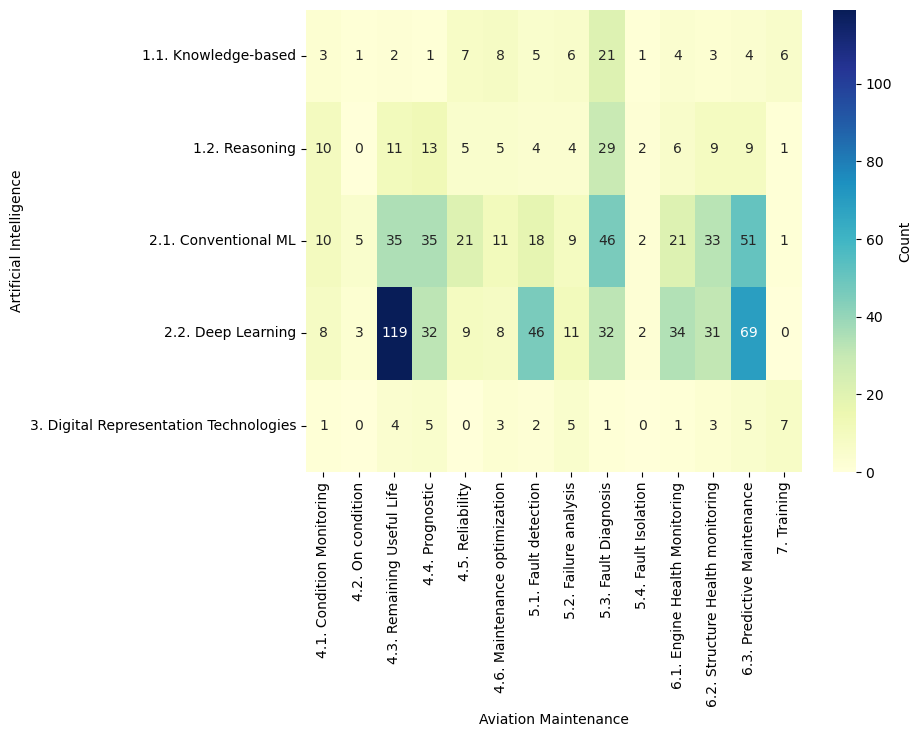

In [22]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="g", cbar_kws={'label': 'Count'})
plt.xlabel("Aviation Maintenance")
plt.ylabel("Artificial Intelligence")
plt.show()

Crosstab with row and column shares

In [23]:
column_shares = crosstab.div(crosstab.sum(axis=0),axis=1) * 100
column_shares = column_shares.fillna(0)
row_shares = crosstab.div(crosstab.sum(axis=1),axis=0) * 100
row_shares = row_shares.fillna(0)

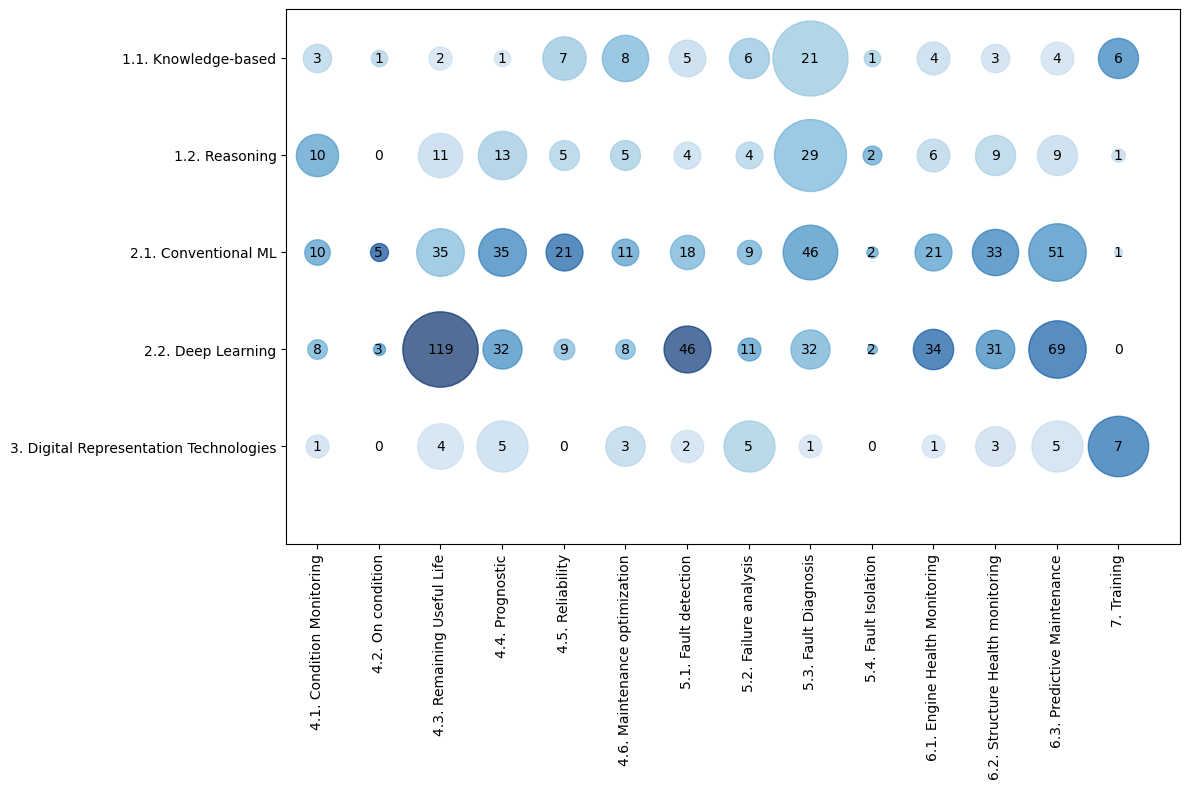

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-0.5, crosstab.shape[1])
ax.set_ylim(-0.5, crosstab.shape[0]) 
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        value = crosstab.iloc[i, j]
        size = row_shares.iloc[i, j]*100
        color = 0.2+column_shares.iloc[i, j]/80
        ax.scatter(j, i, s=size, color=plt.cm.get_cmap('Blues')(color), alpha=0.7)
        ax.text(j, i, f"{value:.0f}", ha='center', va='center', color='black', fontsize=10)
ax.set_xticks(range(crosstab.shape[1]))
ax.set_yticks(range(crosstab.shape[0]))
ax.set_xticklabels(crosstab.columns, rotation=90)
ax.set_yticklabels(crosstab.index)
ax.invert_yaxis()
plt.subplots_adjust(top=0.9, bottom=0.2)
fig.tight_layout()
plt.show()